# Scan MERRA-2 atmospheric properties during one month
------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation November 26 Novembre 2016
- update April 25th 2018

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One year of MERRA-2 predictions of the dataset inst1_2d_asm_Nx_M2I1NXASM over one month. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.


## 1) python libraries
---------------------------

In [48]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
import datetime

In [50]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [51]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [52]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [53]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [54]:
import h5py

In [55]:
import libGMAOMERRA2Data as merra2  # My own library

In [56]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [57]:
# SELECT MONTH IN 2017
MONTH_NAME='06' # select jun

In [58]:
# SELECT OBSERVATORY
OBS_NAME='ctio'

In [59]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM"
HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2I1NXASM_V5.12.4_20180424_201411"

In [60]:
path=HDFEOS_ZOO_DIR

In [61]:
# The selected data field
DATA_NAME =  'inst1_2d_asm_Nx_M2I1NXASM'   # Select Ozone column Depth

In [62]:
pandas_filename='MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'.csv'

In [63]:
fits_filename='MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME +'.fits'

In [64]:
figfile_ozone='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_ozone'+'.jpg'
figfile_pwv='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_pwv'+'.jpg'

In [65]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [66]:
loc

(-70.815, -30.165277777777778, 2214.9999999993697)

### 2.2) Getting the list of the files
------------------------------

In [67]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [68]:
nc4_files[:5]

['MERRA2_400.inst1_2d_asm_Nx.20170502.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20170522.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20170511.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20170616.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20170603.nc4']

### 2.3) Select files of a given month

In [69]:
keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.2017{}.*'.format(MONTH_NAME)

In [70]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.inst1_2d_asm_Nx.201706.*


In [71]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [72]:
nc4_files2

array(['MERRA2_400.inst1_2d_asm_Nx.20170616.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170603.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170615.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170613.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170619.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170607.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170605.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170623.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170614.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170627.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170620.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170626.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170622.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170624.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170618.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170604.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170602.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170625.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170610.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20170609.nc4',


### 2.4) Sort files by increasing time

In [73]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [74]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [75]:
to3_timeseries=[] # example of time series for ozone
pwv_timeseries=[] # time series for precipitable water vapor
df_inst1_2d_asm_Nx=[] # dataset for all atmospheric quantities

for file in full_nc4files:
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print 'start_time = ', start_time
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
    # Retrieve Ozone
    (m_to3_data,m_to3_unit,m_to3_longname)=merra2.GetGeoRefData(file,'TO3') # 3D array : time x longitude x latitude  
    to3=m_to3_data[:,sel_lat,sel_long]
    ts = pd.Series(to3, index=time_rng)
    to3_timeseries.append(ts)
    # Retrieve PWV
    (m_pwv_data,m_pwv_unit,m_pwv_longname)=merra2.GetGeoRefData(file,'TQV')
    pwv=m_pwv_data[:,sel_lat,sel_long]
    ts = pd.Series(pwv, index=time_rng)
    pwv_timeseries.append(ts)
    
    
    # Create the dataframe
    df = pd.DataFrame({'ozone': to3 , 'pwv' : pwv}, index=time_rng)
    df_inst1_2d_asm_Nx.append(df)  
    

start_time =  ['2017-06-01 00:00:00']
start_time =  ['2017-06-02 00:00:00']
start_time =  ['2017-06-03 00:00:00']
start_time =  ['2017-06-04 00:00:00']
start_time =  ['2017-06-05 00:00:00']
start_time =  ['2017-06-06 00:00:00']
start_time =  ['2017-06-07 00:00:00']
start_time =  ['2017-06-08 00:00:00']
start_time =  ['2017-06-09 00:00:00']
start_time =  ['2017-06-10 00:00:00']
start_time =  ['2017-06-11 00:00:00']
start_time =  ['2017-06-12 00:00:00']
start_time =  ['2017-06-13 00:00:00']
start_time =  ['2017-06-14 00:00:00']
start_time =  ['2017-06-15 00:00:00']
start_time =  ['2017-06-16 00:00:00']
start_time =  ['2017-06-17 00:00:00']
start_time =  ['2017-06-18 00:00:00']
start_time =  ['2017-06-19 00:00:00']
start_time =  ['2017-06-20 00:00:00']
start_time =  ['2017-06-21 00:00:00']
start_time =  ['2017-06-22 00:00:00']
start_time =  ['2017-06-23 00:00:00']
start_time =  ['2017-06-24 00:00:00']
start_time =  ['2017-06-25 00:00:00']
start_time =  ['2017-06-26 00:00:00']
start_time =

## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [76]:
result = pd.concat(to3_timeseries)

Text(0,0.5,u'ozone')

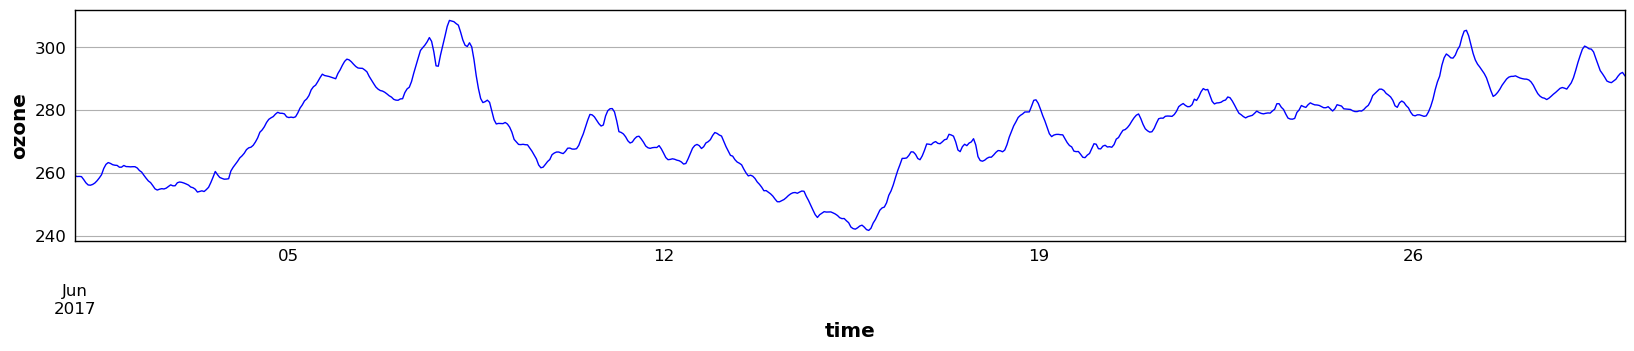

In [77]:
plt.figure(figsize=(20,3))
result.plot(grid=True,color='blue')
plt.xlabel('time')
plt.ylabel('ozone')

In [78]:
result = pd.concat(pwv_timeseries)

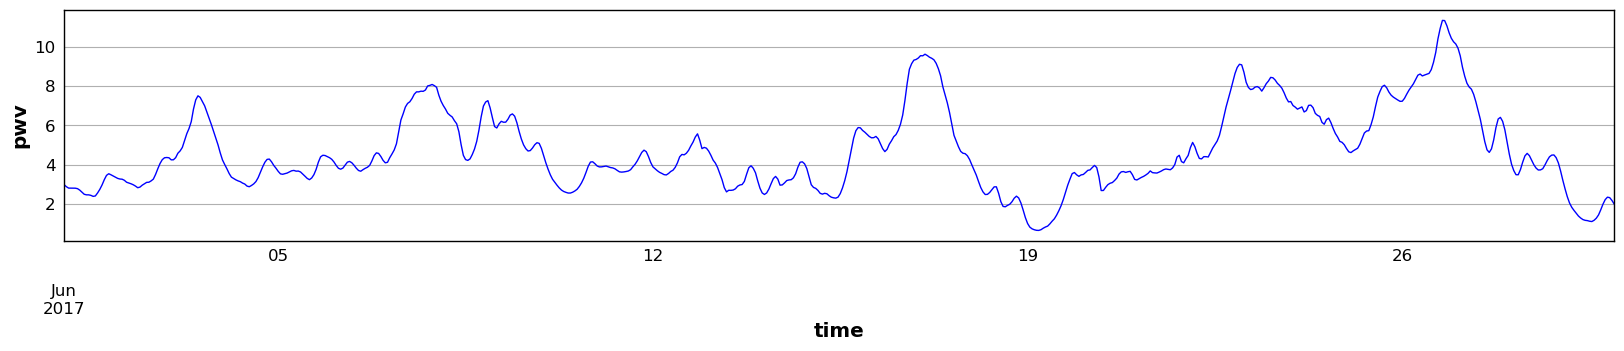

In [79]:
plt.figure(figsize=(20,3))
result.plot(color='blue')
plt.xlabel('time')
plt.ylabel('pwv')
plt.grid(True)

In [80]:
df_inst1_2d_asm_Nx_tot=pd.concat(df_inst1_2d_asm_Nx)

In [81]:
df_inst1_2d_asm_Nx_tot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 696 entries, 2017-06-01 00:00:00 to 2017-06-29 23:00:00
Data columns (total 2 columns):
ozone    696 non-null float32
pwv      696 non-null float32
dtypes: float32(2)
memory usage: 10.9 KB


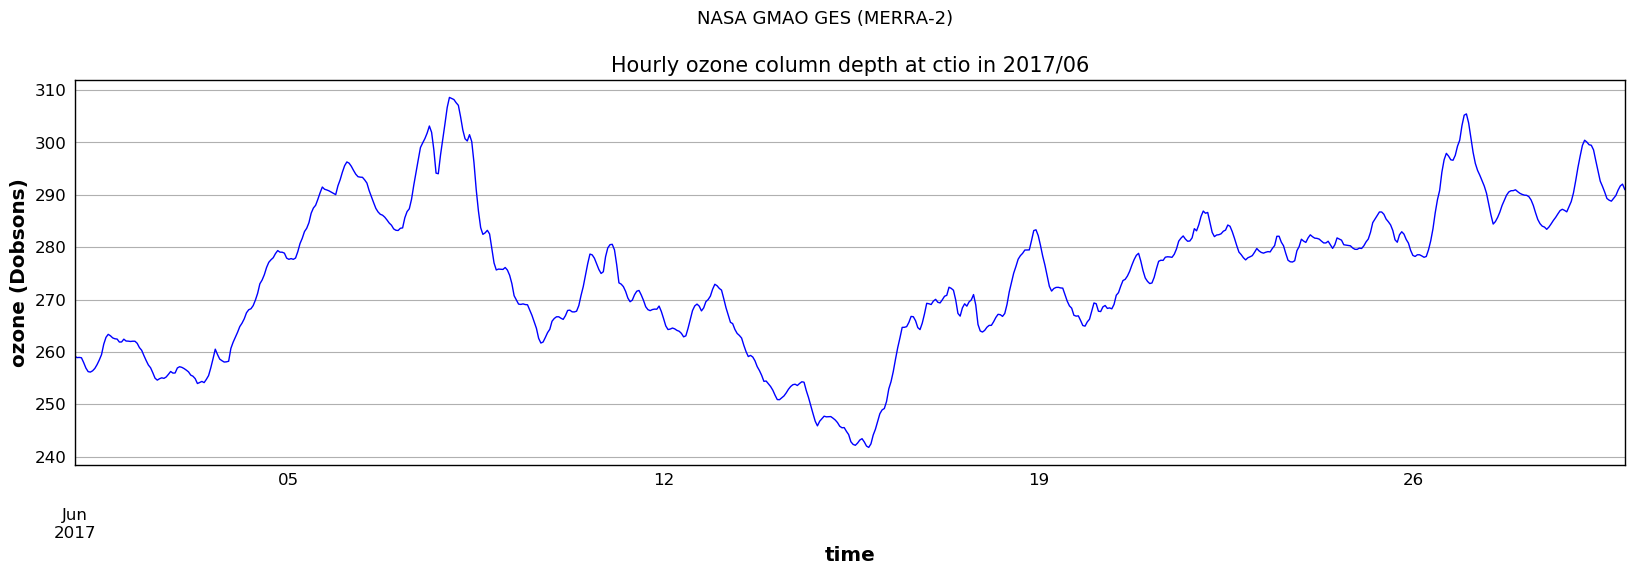

In [82]:
plt.figure(figsize=(20,5))
df_inst1_2d_asm_Nx_tot['ozone'].plot(color='blue')
plt.xlabel('time')
plt.ylabel('ozone (Dobsons)')
title= "Hourly ozone column depth at {} in 2017/{}".format(OBS_NAME,MONTH_NAME)
plt.title(title,fontsize=15)
plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
plt.grid(True)
plt.savefig(figfile_ozone)


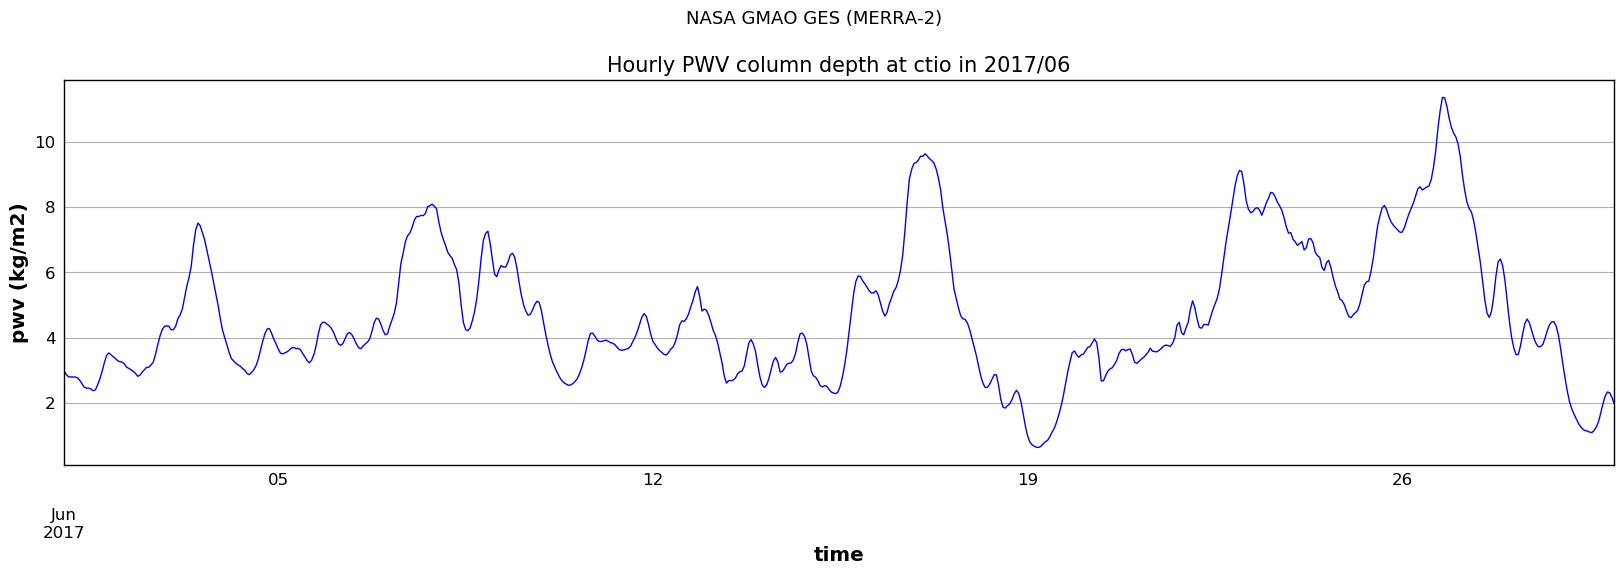

In [83]:
plt.figure(figsize=(20,5))
df_inst1_2d_asm_Nx_tot['pwv'].plot(color='blue')
plt.xlabel('time')
plt.ylabel('pwv (kg/m2)')
title= "Hourly PWV column depth at {} in 2017/{}".format(OBS_NAME,MONTH_NAME)
plt.title(title,fontsize=15)
plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
plt.grid(True)
plt.savefig(figfile_pwv)

In [84]:
df_inst1_2d_asm_Nx_tot.index.name='time'
df_inst1_2d_asm_Nx_tot.describe()

,ozone,pwv
count,696.000000,696.000000
mean,274.455383,4.703155
std,14.163953,2.100082
min,241.780853,0.637064
25%,264.803543,3.259303
50%,275.751633,4.148660
75%,283.758072,6.061206
max,308.591034,11.366414


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [85]:
dataset=df_inst1_2d_asm_Nx_tot

In [86]:
dataset.index.name='time'

In [87]:
dataset.describe()

,ozone,pwv
count,696.000000,696.000000
mean,274.455383,4.703155
std,14.163953,2.100082
min,241.780853,0.637064
25%,264.803543,3.259303
50%,275.751633,4.148660
75%,283.758072,6.061206
max,308.591034,11.366414


In [88]:
dataset.head()

,ozone,pwv
time,,
2017-06-01 00:00:00,259.200836,2.972288
2017-06-01 01:00:00,258.922546,2.871048
2017-06-01 02:00:00,258.957184,2.799065
2017-06-01 03:00:00,258.896149,2.797239
2017-06-01 04:00:00,257.965302,2.793640


In [89]:
dataset.to_csv(pandas_filename)

In [90]:
saved_dataset=pd.read_csv(pandas_filename)

In [91]:
saved_dataset.head()

,time,ozone,pwv
0,2017-06-01 00:00:00,259.200836,2.972288
1,2017-06-01 01:00:00,258.922546,2.871048
2,2017-06-01 02:00:00,258.957184,2.799065
3,2017-06-01 03:00:00,258.896149,2.797239
4,2017-06-01 04:00:00,257.965302,2.793640


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [92]:
table = Table.from_pandas(saved_dataset)

In [93]:
table

time,ozone,pwv
str19,float64,float64
2017-06-01 00:00:00,259.200836182,2.97228813171
2017-06-01 01:00:00,258.922546387,2.87104845047
2017-06-01 02:00:00,258.957183838,2.79906535149
2017-06-01 03:00:00,258.896148682,2.79723930359
2017-06-01 04:00:00,257.965301514,2.7936398983
2017-06-01 05:00:00,256.921264648,2.79438948631
2017-06-01 06:00:00,256.246887207,2.77056860924
2017-06-01 07:00:00,256.158966064,2.69508194923
2017-06-01 08:00:00,256.403503418,2.58580470085


In [94]:
table.write(fits_filename,format='fits',overwrite=True)